In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

### Scraping of Wikipedia with BeautifulSoup

In [2]:
r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(r.content)

table = soup.find_all('table')
df = pd.read_html(str(table))[0]

df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


### Cleaning of Toronto Postal Code DataFrame

In [3]:
toronto_df = df[df['Borough'] != 'Not assigned']

toronto_df = toronto_df.groupby(['Postal Code', 'Borough'], as_index = False).agg(','.join)
toronto_df

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


### Merging of Longitude and Latitude with DataFrame

In [4]:
url = 'http://cocl.us/Geospatial_data'
latlng_df = pd.read_csv(url)
latlng_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
toronto_latlng_df = pd.merge(toronto_df, latlng_df, on = 'Postal Code')
toronto_latlng_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Exploring Toronto Neighborhoods with Foursquare API

In [6]:
#API Authentication Details
clientID = 'OZLYR1RSTAXMP5HJRILIEUSZIJIOO54AZUDCIPH5QT2ODLQA'
clientSecret = 'S0LVUF2PIAM1RQDP1G01TYY3JPJIHAVTUAWJXC5J4PHO002K'
version = '20200721'

In [7]:
def getNearby(postcode, latitude, longitude):
    radius = 2000
    limit = 300
    venues_list=[]
    
    for postcode, lat, lng in zip(postcode, latitude, longitude):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            clientID, 
            clientSecret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostCode', 
                  'PostCode Latitude', 
                  'PostCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
toronto_venues = getNearby(toronto_latlng_df['Postal Code'], 
                           toronto_latlng_df['Latitude'], 
                           toronto_latlng_df['Longitude'])

print(toronto_venues.shape)
toronto_venues.head()

(8648, 7)


,PostCode,PostCode Latitude,PostCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
2,M1B,43.806686,-79.194353,Toronto Pan Am Sports Centre,43.790623,-79.193869,Athletics & Sports
3,M1B,43.806686,-79.194353,Toronto Zoo,43.820582,-79.181551,Zoo
4,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit


### Pre-Processing of Venue Category for Clustering

In [9]:
venue_cat = pd.get_dummies(toronto_venues[['Venue Category']], columns=['Venue Category'], prefix = "", prefix_sep = "")
venue_cat['PostCode'] = toronto_venues['PostCode']
venue_grouped = venue_cat.groupby('PostCode').mean().reset_index()
venue_grouped

,PostCode,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Argentinian Restaurant,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,0.0,0.0,0.019608,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.039216,0.294118
1,M1C,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000000
2,M1E,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000000
3,M1G,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000000
4,M1H,0.0,0.0,0.000000,0.0,0.020000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.020000,0.0,0.01,0.01,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000000
99,M9P,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000000
100,M9R,0.0,0.0,0.000000,0.0,0.014706,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029412,0.0,0.00,0.00,0.000000,0.000000
101,M9V,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000000


### KMeans Clustering

<function matplotlib.pyplot.show(*args, **kw)>

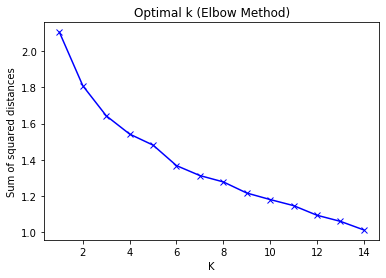

In [10]:
# Identification of Optimal k
venue_group_cluster = venue_grouped.drop('PostCode', 1)

squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(venue_group_cluster)
    squared_distances.append(km.inertia_)
    
plt.plot(K, squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('Optimal k (Elbow Method)')
plt.show

In [12]:
#True = False
# Number of Clusters
k = 6

kmeans = KMeans(n_clusters = k, random_state = 0).fit(venue_group_cluster)

labels = kmeans.labels_
labels = labels + 1 # Set Cluster No. to start at 1
labels

array([6, 1, 1, 5, 1, 5, 5, 5, 4, 1, 5, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 5, 5, 5, 4, 4, 4, 4, 4, 2, 2, 2, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 5, 5, 4, 2, 2, 2, 2, 1, 2,
       4, 4, 4, 4, 4, 4, 1, 1, 5, 4, 5, 1, 1, 5, 1])

### Creating new dataframe for understanding of clusters

In [13]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostCode', 'Cluster']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postcode_venues_sorted = pd.DataFrame(columns=columns)
postcode_venues_sorted['PostCode'] = venue_grouped['PostCode']
postcode_venues_sorted['Cluster'] = labels


for ind in np.arange(venue_grouped.shape[0]):
    row = venue_grouped.iloc[ind, :]
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    postcode_venues_sorted.iloc[ind, 2:] = row_categories_sorted.index.values[0:num_top_venues]

postcode_venues_sorted

,PostCode,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M1C,1,Coffee Shop,Breakfast Spot,Pharmacy,Pet Store,Sandwich Place,Bank,Ice Cream Shop,Mexican Restaurant,Grocery Store,Beer Store
2,M1E,1,Pizza Place,Coffee Shop,Breakfast Spot,Park,Grocery Store,Fast Food Restaurant,Bank,Athletics & Sports,Sports Bar,Greek Restaurant
4,M1H,1,Coffee Shop,Clothing Store,Gas Station,Gym,Sandwich Place,Bank,Restaurant,Indian Restaurant,Pizza Place,Fast Food Restaurant
9,M1N,1,Coffee Shop,Grocery Store,Golf Course,Gas Station,Bank,Beer Store,Pizza Place,Ice Cream Shop,Convenience Store,Supermarket
11,M1R,1,Coffee Shop,Restaurant,Fast Food Restaurant,Pizza Place,Middle Eastern Restaurant,Burger Joint,Indian Restaurant,Vietnamese Restaurant,Breakfast Spot,Sandwich Place
12,M1S,1,Chinese Restaurant,Coffee Shop,Restaurant,Pharmacy,Sandwich Place,Discount Store,Indian Restaurant,Bank,Shopping Mall,Caribbean Restaurant
13,M1T,1,Bank,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Restaurant,Gas Station,Pharmacy,Pizza Place,Sandwich Place,Men's Store
14,M1V,1,Chinese Restaurant,Coffee Shop,Korean Restaurant,Bakery,Pizza Place,Gas Station,Vietnamese Restaurant,Noodle House,Dessert Shop,Park
15,M1W,1,Chinese Restaurant,Coffee Shop,Sandwich Place,Bank,Bakery,Pharmacy,Japanese Restaurant,Fast Food Restaurant,Breakfast Spot,Pool
17,M2H,1,Coffee Shop,Chinese Restaurant,Bank,Park,Sandwich Place,Pharmacy,Bakery,Japanese Restaurant,Pizza Place,Sushi Restaurant


In [14]:
# Identifying all Transport-related venues
df_station = toronto_venues[toronto_venues['Venue Category'].str.contains('Station$') |
                       toronto_venues['Venue Category'].str.contains('^Bus')]
df_station = df_station[df_station['Venue Category'] != 'Gas Station']
df_station['Venue Category'].unique()

array(['Bus Station', 'Train Station', 'Bus Line', 'Bus Stop',
       'Light Rail Station', 'Metro Station'], dtype=object)

In [15]:
postcode_station = df_station.groupby('PostCode').count().reset_index()
postcode_station.drop(columns=['PostCode Latitude', 'PostCode Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], inplace = True)
postcode_station.rename(columns = {'Venue Category': 'No. of Transport Hub'}, inplace = True)
postcode_station

,PostCode,No. of Transport Hub
0,M1B,1
1,M1E,1
2,M1K,3
3,M1M,1
4,M1R,1
5,M1S,1
6,M1T,1
7,M1W,2
8,M2H,1
9,M2J,1


In [16]:
postcode_venues = postcode_venues_sorted.merge(postcode_station, how = 'left', on = 'PostCode')
postcode_venues['No. of Transport Hub'] = postcode_venues['No. of Transport Hub'].fillna(0)
postcode_venues = postcode_venues.astype({'No. of Transport Hub' : 'int64'})
postcode_venues

,PostCode,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,No. of Transport Hub
0,M1B,6,Zoo Exhibit,Fast Food Restaurant,Other Great Outdoors,Zoo,Gas Station,Pizza Place,Curling Ice,Bus Station,Caribbean Restaurant,Skating Rink,1
1,M1C,1,Coffee Shop,Breakfast Spot,Pharmacy,Pet Store,Sandwich Place,Bank,Ice Cream Shop,Mexican Restaurant,Grocery Store,Beer Store,0
2,M1E,1,Pizza Place,Coffee Shop,Breakfast Spot,Park,Grocery Store,Fast Food Restaurant,Bank,Athletics & Sports,Sports Bar,Greek Restaurant,1
3,M1G,5,Coffee Shop,Fast Food Restaurant,Sandwich Place,Discount Store,Bank,Supermarket,Pharmacy,Chinese Restaurant,Pizza Place,Beer Store,0
4,M1H,1,Coffee Shop,Clothing Store,Gas Station,Gym,Sandwich Place,Bank,Restaurant,Indian Restaurant,Pizza Place,Fast Food Restaurant,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,5,Coffee Shop,Sandwich Place,Gas Station,Pizza Place,Bakery,Grocery Store,Furniture / Home Store,Bank,Fast Food Restaurant,Fried Chicken Joint,2
99,M9P,1,Coffee Shop,Grocery Store,Bank,Sandwich Place,Pizza Place,Bakery,Park,Train Station,Gas Station,Beer Store,2
100,M9R,1,Coffee Shop,Pizza Place,Sandwich Place,Hotel,Pharmacy,Restaurant,Bank,Gas Station,Supermarket,Wings Joint,0
101,M9V,5,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Pizza Place,Grocery Store,Park,Bank,Skating Rink,Sandwich Place,Ice Cream Shop,0


### Cluster 1

In [17]:
postcode_venues[postcode_venues['Cluster'] == 1]

,PostCode,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,No. of Transport Hub
1,M1C,1,Coffee Shop,Breakfast Spot,Pharmacy,Pet Store,Sandwich Place,Bank,Ice Cream Shop,Mexican Restaurant,Grocery Store,Beer Store,0
2,M1E,1,Pizza Place,Coffee Shop,Breakfast Spot,Park,Grocery Store,Fast Food Restaurant,Bank,Athletics & Sports,Sports Bar,Greek Restaurant,1
4,M1H,1,Coffee Shop,Clothing Store,Gas Station,Gym,Sandwich Place,Bank,Restaurant,Indian Restaurant,Pizza Place,Fast Food Restaurant,0
9,M1N,1,Coffee Shop,Grocery Store,Golf Course,Gas Station,Bank,Beer Store,Pizza Place,Ice Cream Shop,Convenience Store,Supermarket,0
11,M1R,1,Coffee Shop,Restaurant,Fast Food Restaurant,Pizza Place,Middle Eastern Restaurant,Burger Joint,Indian Restaurant,Vietnamese Restaurant,Breakfast Spot,Sandwich Place,1
12,M1S,1,Chinese Restaurant,Coffee Shop,Restaurant,Pharmacy,Sandwich Place,Discount Store,Indian Restaurant,Bank,Shopping Mall,Caribbean Restaurant,1
13,M1T,1,Bank,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Restaurant,Gas Station,Pharmacy,Pizza Place,Sandwich Place,Men's Store,1
14,M1V,1,Chinese Restaurant,Coffee Shop,Korean Restaurant,Bakery,Pizza Place,Gas Station,Vietnamese Restaurant,Noodle House,Dessert Shop,Park,0
15,M1W,1,Chinese Restaurant,Coffee Shop,Sandwich Place,Bank,Bakery,Pharmacy,Japanese Restaurant,Fast Food Restaurant,Breakfast Spot,Pool,2
17,M2H,1,Coffee Shop,Chinese Restaurant,Bank,Park,Sandwich Place,Pharmacy,Bakery,Japanese Restaurant,Pizza Place,Sushi Restaurant,1


### Cluster 2

In [18]:
postcode_venues[postcode_venues['Cluster'] == 2]

,PostCode,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,No. of Transport Hub
22,M2N,2,Grocery Store,Korean Restaurant,Ramen Restaurant,Supermarket,Bubble Tea Shop,Café,Sushi Restaurant,Theater,Thai Restaurant,Coffee Shop,0
40,M4J,2,Café,Greek Restaurant,Coffee Shop,Bakery,Ice Cream Shop,Gastropub,American Restaurant,Ethiopian Restaurant,Park,Cocktail Bar,0
41,M4K,2,Café,Greek Restaurant,Park,Bakery,Coffee Shop,Ice Cream Shop,American Restaurant,Italian Restaurant,Vietnamese Restaurant,Pub,0
42,M4L,2,Park,Brewery,Café,Coffee Shop,Beach,Bar,BBQ Joint,Pizza Place,Bakery,American Restaurant,0
43,M4M,2,Coffee Shop,Park,Brewery,Bakery,Bar,Café,Vietnamese Restaurant,Diner,French Restaurant,Pet Store,0
45,M4P,2,Coffee Shop,Italian Restaurant,Park,Bakery,Café,Sushi Restaurant,Restaurant,Indian Restaurant,Japanese Restaurant,Pizza Place,0
46,M4R,2,Italian Restaurant,Coffee Shop,Sushi Restaurant,Bakery,Café,Fast Food Restaurant,Japanese Restaurant,Park,Burger Joint,Dessert Shop,0
47,M4S,2,Italian Restaurant,Park,Bakery,Coffee Shop,Café,Sushi Restaurant,Restaurant,Indian Restaurant,Yoga Studio,Bookstore,0
48,M4T,2,Park,Italian Restaurant,Sushi Restaurant,Bakery,Café,Coffee Shop,Dessert Shop,Restaurant,Grocery Store,Thai Restaurant,0
49,M4V,2,Italian Restaurant,Coffee Shop,Park,Café,Sushi Restaurant,French Restaurant,Ice Cream Shop,Grocery Store,Spa,Hotel,0


### Cluster 3

In [19]:
postcode_venues[postcode_venues['Cluster'] == 3]

,PostCode,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,No. of Transport Hub
16,M1X,3,Grocery Store,Golf Course,Playground,Sculpture Garden,Trail,Farm,Farmers Market,Ethiopian Restaurant,Event Service,Event Space,0


### Cluster 4

In [23]:
postcode_venues[postcode_venues['Cluster'] == 4]

,PostCode,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,No. of Transport Hub
8,M1M,4,Harbor / Marina,Park,Coffee Shop,Sandwich Place,Beach,Pub,Grocery Store,Fast Food Restaurant,Pizza Place,Pharmacy,1
30,M3K,4,Clothing Store,Furniture / Home Store,Athletics & Sports,Coffee Shop,American Restaurant,Cosmetics Shop,Vietnamese Restaurant,Pizza Place,Restaurant,Pharmacy,0
35,M4B,4,Pizza Place,Park,Coffee Shop,Skating Rink,Sandwich Place,Ice Cream Shop,Athletics & Sports,Fast Food Restaurant,Beer Store,Convenience Store,0
36,M4C,4,Park,Coffee Shop,Café,Gastropub,Pizza Place,Skating Rink,Ethiopian Restaurant,Thai Restaurant,Ice Cream Shop,Breakfast Spot,2
37,M4E,4,Coffee Shop,Pub,Breakfast Spot,Beach,Japanese Restaurant,Bakery,BBQ Joint,Ice Cream Shop,Park,Grocery Store,0
38,M4G,4,Coffee Shop,Indian Restaurant,Park,Bakery,Grocery Store,Restaurant,Afghan Restaurant,Turkish Restaurant,Sporting Goods Shop,Sandwich Place,0
39,M4H,4,Coffee Shop,Park,Sandwich Place,Grocery Store,Restaurant,Pizza Place,Indian Restaurant,Pharmacy,Japanese Restaurant,Bakery,0
44,M4N,4,Coffee Shop,Park,Sushi Restaurant,Italian Restaurant,Bakery,Pharmacy,Pizza Place,Pub,Sandwich Place,Restaurant,1
62,M5M,4,Coffee Shop,Italian Restaurant,Sushi Restaurant,Bakery,Bagel Shop,Sandwich Place,Restaurant,Pharmacy,Pizza Place,Pub,2
71,M6A,4,Clothing Store,Coffee Shop,Fast Food Restaurant,Furniture / Home Store,Dessert Shop,Grocery Store,Vietnamese Restaurant,Bank,Pizza Place,Cosmetics Shop,0


### Cluster 5

In [21]:
postcode_venues[postcode_venues['Cluster'] == 5]

,PostCode,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,No. of Transport Hub
3,M1G,5,Coffee Shop,Fast Food Restaurant,Sandwich Place,Discount Store,Bank,Supermarket,Pharmacy,Chinese Restaurant,Pizza Place,Beer Store,0
5,M1J,5,Coffee Shop,Fast Food Restaurant,Pizza Place,Sandwich Place,Pharmacy,Grocery Store,Liquor Store,Bank,Gym,Beer Store,0
6,M1K,5,Grocery Store,Pharmacy,Chinese Restaurant,Coffee Shop,Discount Store,Fast Food Restaurant,Beer Store,Bank,Sandwich Place,Pizza Place,3
7,M1L,5,Coffee Shop,Fast Food Restaurant,Sandwich Place,Pizza Place,Restaurant,Hardware Store,Clothing Store,Beer Store,Burger Joint,Burrito Place,0
10,M1P,5,Coffee Shop,Fast Food Restaurant,Pizza Place,Sandwich Place,Restaurant,Indian Restaurant,Breakfast Spot,Bank,Gas Station,Pharmacy,0
32,M3M,5,Pharmacy,Coffee Shop,Pizza Place,Bank,Fast Food Restaurant,Vietnamese Restaurant,Grocery Store,Gas Station,Supermarket,Sandwich Place,0
33,M3N,5,Coffee Shop,Hotel,Fast Food Restaurant,Gas Station,Pizza Place,Grocery Store,Kitchen Supply Store,Latin American Restaurant,Theater,Tennis Stadium,0
34,M4A,5,Coffee Shop,Fast Food Restaurant,Gym,Sandwich Place,Clothing Store,Japanese Restaurant,Grocery Store,Middle Eastern Restaurant,Department Store,Gas Station,0
79,M6L,5,Vietnamese Restaurant,Coffee Shop,Fast Food Restaurant,Gas Station,Pizza Place,Furniture / Home Store,Bank,Bakery,Supermarket,Grocery Store,0
80,M6M,5,Coffee Shop,Furniture / Home Store,Sandwich Place,Fast Food Restaurant,Pizza Place,Gas Station,Grocery Store,Bakery,Burger Joint,Italian Restaurant,0


### Cluster 6

In [22]:
postcode_venues[postcode_venues['Cluster'] == 6]

,PostCode,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,No. of Transport Hub
0,M1B,6,Zoo Exhibit,Fast Food Restaurant,Other Great Outdoors,Zoo,Gas Station,Pizza Place,Curling Ice,Bus Station,Caribbean Restaurant,Skating Rink,1
